In [1]:
%pylab inline
import numpy as np
import jax
import jax.numpy as jnp

Populating the interactive namespace from numpy and matplotlib


## Load the MassiveNuS convergence dataset

See http://www.columbialensing.org/#massivenus for more information

## Shape catalog

From the HSC-XMM field shape catalog generate:
- noise covariance matrix
- survey mask
- e1, e2 maps

In [2]:
from astropy.table import Table
from astropy.io import fits

In [3]:
cat = Table.read('../data/hsc_catalog_xmm.fits')

In [4]:
# Applying extra cut on photoz from the paper
#cat = cat[cat['photoz_std_best'] < 0.3]

In [5]:
survey_cut = (cat['ira']>35.5) * (cat['ira']<38.5) * (cat['idec']>-6) * (cat['idec']<-3)

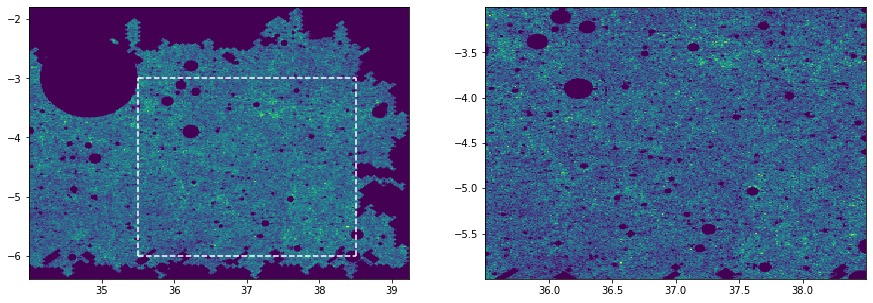

In [6]:
figure(figsize=[15,5])
subplot(121)
hist2d(cat['ira'], cat['idec'], 256);
hlines(y=-3,xmin=35.5, xmax=38.5, color='w', linestyle='--')
hlines(y=-6,xmin=35.5, xmax=38.5, color='w', linestyle='--')
vlines(x=35.5,ymin=-6, ymax=-3, color='w', linestyle='--')
vlines(x=38.5,ymin=-6, ymax=-3, color='w', linestyle='--')

subplot(122)
hist2d(cat['ira'][survey_cut], cat['idec'][survey_cut], 256);

cat = cat[survey_cut]

Ensure that our assumption of redshift mean is correct

Mean redshift 0.9701822


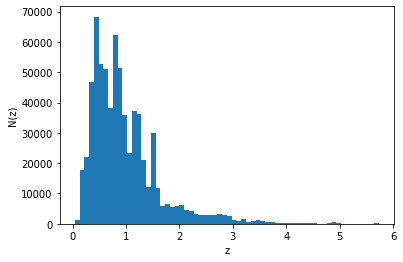

In [7]:
hist(cat['photoz_best'], 64);
xlabel('z')
ylabel('N(z)')
print('Mean redshift', np.mean(cat['photoz_best']))

Bin the catalog using [lenspack](https://github.com/CosmoStat/lenspack/tree/master/lenspack).

In [8]:
from lenspack.utils import bin2d

# Compute boundaries of the field so that it fits in a 360x360 map
# MassiveNuS maps beging 512x512 with 0.4 arcmin resolution, we resize them to 360x360
resolution = 512/360*0.4
pixel_size = np.pi * resolution / 180. / 60. #rad/pixel
width = 360
size = width * resolution / 60.

ra = median(cat['ira'])
dec = median(cat['idec'])
extent = [ra - size/2, ra + size/2, dec - size/2, dec + size/2]

In [9]:
# We need to convert ellipticity to shear and calibrate it
# Step I: computing the shear responsivity
R = 1 - np.sum( cat['ishape_hsm_regauss_derived_shape_weight'] *
                cat['ishape_hsm_regauss_derived_rms_e']**2) / np.sum(cat['ishape_hsm_regauss_derived_shape_weight'])

mbar = np.sum( cat['ishape_hsm_regauss_derived_shape_weight'] *
               cat['ishape_hsm_regauss_derived_shear_bias_m']) / np.sum(cat['ishape_hsm_regauss_derived_shape_weight'])


cat['gamma1'] = 1./(1+mbar)*(cat['ishape_hsm_regauss_e1']/(2 * R) -
                             cat['ishape_hsm_regauss_derived_shear_bias_c1'])

cat['gamma2'] = 1./(1+mbar)*(cat['ishape_hsm_regauss_e2']/(2 * R) -
                             cat['ishape_hsm_regauss_derived_shear_bias_c2'])

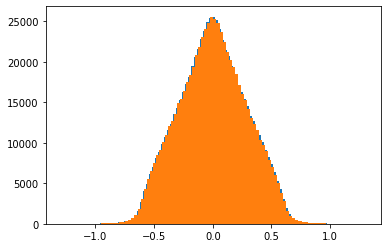

In [10]:
hist(cat['gamma1'],100);
hist(cat['gamma2'],100);

In [11]:
std(cat['gamma1']), std(cat['gamma2'])

(0.28697693, 0.2881893)

**Number of galaxy per pixel map**

In [12]:
from quarks2cosmos.utils import get_extend_radec

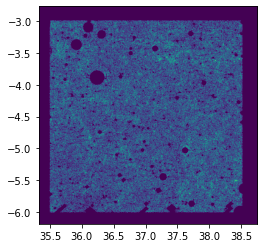

In [13]:
n_gal_map = bin2d(cat['ira'], cat['idec'],
                  npix=width,
                  extent=extent)
imshow(n_gal_map, origin='lower', extent=get_extend_radec(resolution, width,ra, dec))

**Survey mask**

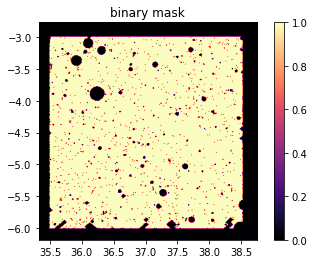

In [14]:
m = n_gal_map == 0
mask = 1. - m
imshow(mask, cmap='magma', origin='lower', extent=get_extend_radec(resolution, width, ra, dec))
colorbar()
#xlim(gca().get_xlim()[::-1])
title("binary mask")

mask = np.expand_dims(mask, -1)

**Ellipticity maps**

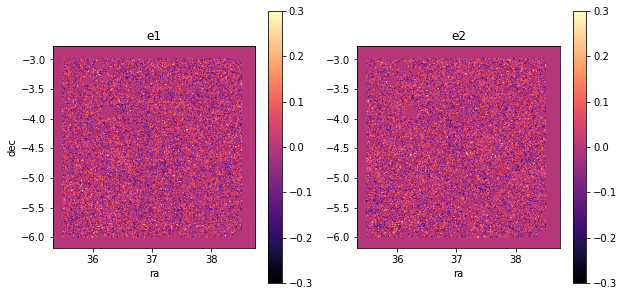

In [15]:
# Bin ellipticity components based on galaxy position into a 360x360 map
e1map, e2map = bin2d(cat['ira'], cat['idec'], 
                     v=(cat['gamma1'], cat['gamma2']), 
                     npix=width,
                     extent=extent)

figure(figsize=[10,5])
subplot(121)
imshow(e1map, cmap='magma', origin='lower', extent=get_extend_radec(resolution, width, ra, dec),vmin=-0.3,vmax=0.3)
#xlim(gca().get_xlim()[::-1])
colorbar()
xlabel('ra')
ylabel('dec')
title('e1')

subplot(122)
imshow(e2map, cmap='magma', origin='lower', extent=get_extend_radec(resolution, width, ra, dec),vmin=-0.3,vmax=0.3)
colorbar()
#xlim(gca().get_xlim()[::-1])
xlabel('ra')
title('e2')

meas_shear = np.stack([e1map, e2map], axis=-1)

**Noise covariance matrix**

<ipython-input-16-146355e0f0c6>:2: RuntimeWarning: divide by zero encountered in true_divide
  sigma_e1 = np.std(cat['gamma1'])/np.sqrt(n_gal_map)
<ipython-input-16-146355e0f0c6>:4: RuntimeWarning: divide by zero encountered in true_divide
  sigma_e2 = np.std(cat['gamma2'])/np.sqrt(n_gal_map)


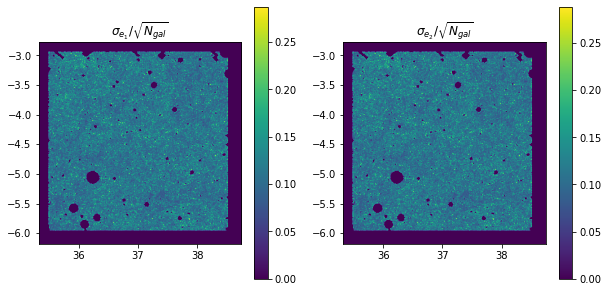

In [16]:
mask = n_gal_map == 0
sigma_e1 = np.std(cat['gamma1'])/np.sqrt(n_gal_map)
sigma_e1[mask] = 0
sigma_e2 = np.std(cat['gamma2'])/np.sqrt(n_gal_map)
sigma_e2[mask] = 0

figure(figsize=[10, 5])
subplot(121)
imshow(sigma_e1, extent=get_extend_radec(resolution, width, ra, dec))
title(r'$\sigma_{e_1}/\sqrt{N_{gal}}$')
colorbar()

subplot(122)
imshow(sigma_e2, extent=get_extend_radec(resolution, width, ra, dec))
title(r'$\sigma_{e_2}/\sqrt{N_{gal}}$')

colorbar()

## Kaiser-Squires solution

Use the first mass-mapping technique [Kaiser-Squires (1993)](https://ui.adsabs.harvard.edu/abs/1993ApJ...404..441K/abstract). Smooth the solution with a gaussian filter.

In [17]:
from quarks2cosmos.lensing import ks93, ks93inv
from scipy.ndimage import gaussian_filter

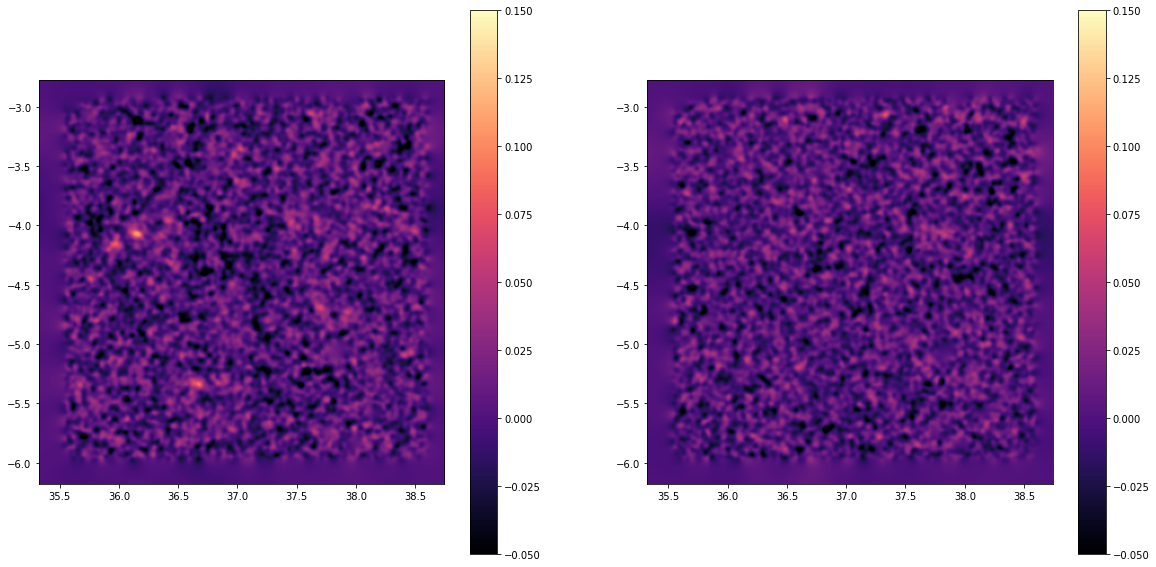

In [18]:
kappaE, kappaB = ks93(e1map, e2map)

kwargs = dict(vmin=-.05, vmax=.15, cmap='magma', extent=get_extend_radec(resolution, width, ra, dec))
figure(figsize=[20,10])
subplot(121)
imshow(gaussian_filter(kappaE,2)[:,::-1], **kwargs);colorbar()
subplot(122)
imshow(gaussian_filter(kappaB,2)[:,::-1], **kwargs);colorbar()

## Wiener filter solution

Get the maximum-a-posteriori (MAP), assuming a Gaussian prior that is characterised by the theoretical power spectrum.

1) The likelihood

In [19]:
def log_likelihood(x, sigma, meas_shear, mask):
    """ Likelihood function at the level of the measured shear
    """
    ke = x[...,0].reshape((360, 360))
    kb = x[...,1].reshape((360, 360))
    model_shear = jnp.stack(ks93inv(ke, kb), axis=-1)
    return - jnp.sum(mask*(model_shear - meas_shear)**2/((sigma_gamma)**2 + sigma**2) )/2.

likelihood_score = jax.vmap(jax.grad(log_likelihood), in_axes=[0,0, None, None])

2) Build a Gaussian prior from the Power Spectrum (computed from [jax-cosmo](https://github.com/DifferentiableUniverseInitiative/jax_cosmo))

Text(0.5, 0, 'Redshift z')

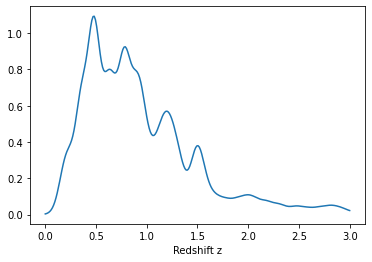

In [36]:
import jax_cosmo as jc
pz = jc.redshift.kde_nz(jnp.array(cat['photoz_best'][:10000].astype('float32')),
                        jnp.ones(10000), bw=0.05)

z = jnp.linspace(0,3,256)
plot(z, pz(z));
xlabel('Redshift z');

In [37]:
cosmo = jc.Planck15()

In [39]:
tracer = jc.probes.WeakLensing([pz])

In [47]:
ell = jnp.logspace(2,5)
cl  = jc.angular_cl.angular_cl(cosmo, ell, [tracer])

/local/home/flanusse/.local/lib/python3.8/site-packages/jax/_src/numpy/lax_numpy.py:5770: UserWarning: Explicitly requested dtype <class 'jax._src.numpy.lax_numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  lax._check_user_dtype_supported(dtype, "astype")


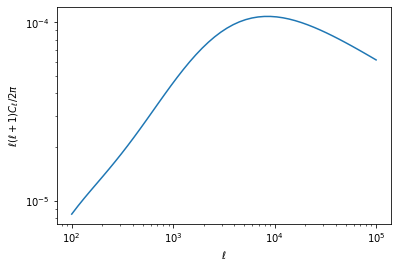

In [52]:
loglog(ell, ell * (ell + 1) * cl[0] / 2 / np.pi)
xlabel(r'$\ell$')
ylabel(r'$\ell  (\ell + 1) C_\ell / 2 \pi$');

In [54]:
ps_data_th = jnp.stack([ell, cl[0]],axis=0)

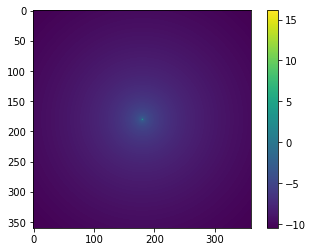

In [55]:
from quarks2cosmos.lensing import make_power_map

power_map_th = np.array(make_power_map(ps_data_th, size=360, pixel_size=pixel_size, ell=True))
imshow(np.log(jnp.fft.fftshift(power_map_th))); colorbar();

In [56]:
def log_gaussian_prior(map_data, sigma, ps_map):
    """
    map_data: array on which to evaluate the log prior
    sigma: temperature
    ps_map: 
    """
    map_data = map_data[...,0].reshape(360, 360)
    data_ft = jnp.fft.fft2(map_data) / 360.
    return -0.5*jnp.sum(jnp.real(data_ft*jnp.conj(data_ft)) / (ps_map+sigma**2))

gaussian_prior_score = jax.vmap(jax.grad(log_gaussian_prior), in_axes=[0,0, None])

3) Compute the MAP

In [57]:
from functools import partial

def log_posterior(x, sigma, ps_map, meas_shear, mask):
    """ Compute the total score, combining the following components:
        gaussian prior, ml prior, data likelihood
    """
    data_score = likelihood_score(x, sigma, meas_shear, mask)
    gaussian_score = gaussian_prior_score(x, sigma, power_map_th)
    return (data_score + gaussian_score).reshape(-1, 360*360*2)

log_posterior = partial(log_posterior, ps_map=power_map_th, meas_shear=meas_shear, mask=mask)

In [58]:
x = np.expand_dims(np.stack([kappaE, kappaB], -1),0)
print(x.shape)
gaussian_prior_score(x, np.zeros((1,1,1)), power_map_th).shape

(1, 360, 360, 2)


(1, 360, 360, 2)

In [72]:
sigma = np.std(np.concatenate([cat['gamma1'], cat['gamma2']])) / np.mean(n_gal_map[~mask])
print(sigma)

0.039709813618080354


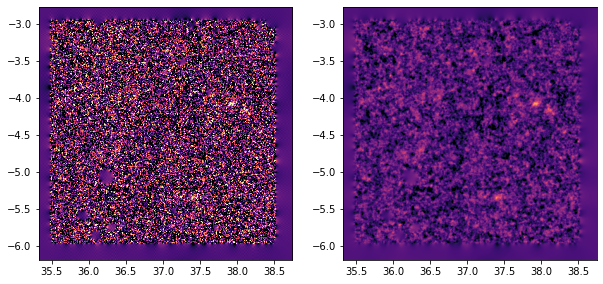

In [76]:
figure(figsize=[10,5])

subplot(121)
imshow(x[0,...,0],**kwargs)
subplot(122)
imshow(x[0,...,0] + sigma**2 * gaussian_prior_score(x, sigma*np.ones((1,1,1)), power_map_th)[0,...,0],**kwargs)